Checking Run 3 signal kinematics against Run 2

Author(s): Raghav Kansal

In [1]:
from __future__ import annotations

import os
import pickle
from collections import OrderedDict

import awkward as ak
import numpy as np
from coffea import nanoevents
from coffea.lookup_tools.dense_lookup import dense_lookup
from hist import Hist
from hist.intervals import ratio_uncertainty

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import mplhep as hep

hep.style.use(["CMS"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 14})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"
plt.rcParams["figure.dpi"] = 100

In [3]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

In [4]:
MAIN_DIR = "../../../"

# plot_dir = f"{MAIN_DIR}/plots/SignalCheck/23Oct27"
plot_dir = f"{MAIN_DIR}/plots/SignalCheck/24Mar27"

_ = os.system(f"mkdir -p {plot_dir}")

In [5]:
run2_sig_path = "/eos/uscms/store/user/lpcpfnano/cmantill/v2_3/2018/HH/GluGluToHHTo4B_node_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8/GluGluToHHTo4B_node_cHHH1_preUL/230217_205036/0000/nano_mc2018_1.root"

# Can't open this directly with Coffea for some reason...
# run3_sig_path = "root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/Run3Summer22EENanoAODv10/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/Poisson70KeepRAW_124X_mcRun3_2022_realistic_postEE_v1-v1/30000/d00363f4-0cac-410d-8fc7-bb6f60ccb6cd.root"
run3_sig_path = "root://cmsdcadisk.fnal.gov//dcache/uscmsdisk/store/mc/Run3Summer22EENanoAODv12/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/NANOAODSIM/130X_mcRun3_2022_realistic_postEE_v6-v1/2540000/24de7598-15b3-4a9b-8adc-26f5b804560d.root"

# run3_sig_path = "/eos/uscms/store/user/rkansal/bbbb/nano/Run3Summer22EENanoAODv10/GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_powheg-pythia8/d00363f4-0cac-410d-8fc7-bb6f60ccb6cd.root"

In [6]:
events_dict = OrderedDict()
events_dict["run2"] = nanoevents.NanoEventsFactory.from_root(
    run2_sig_path, schemaclass=nanoevents.NanoAODSchema
).events()
events_dict["run3"] = nanoevents.NanoEventsFactory.from_root(
    run3_sig_path, schemaclass=nanoevents.NanoAODSchema
).events()

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nBHadrons in <TTree 'Events' (1908 branches) at 0x7f69b49fa5e0>, taking first instance
  warnings.warn(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15SubJet_nCHadrons in <TTree 'Events' (1908 branches) at 0x7f69b49fa5e0>, taking first instance
  warnings.warn(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch FatJetAK15_nBHadrons in <TTree 'Events' (1908 branches) at 0x7f69b49fa5e0>, taking first instance
  warnings.warn(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/coffea/nanoevents/mapping/uproot.py:86: UserWarning: Found duplicate branch

In [7]:
GEN_FLAGS = ["fromHardProcess", "isLastCopy"]
HIGGS_PDGID = 25

higgs_dict = {}
for key, events in events_dict.items():
    genvars = {}
    # finding the two gen higgs
    higgs = events.GenPart[
        (abs(events.GenPart.pdgId) == HIGGS_PDGID) * events.GenPart.hasFlags(GEN_FLAGS)
    ]
    higgs[ak.argsort(higgs.pt, axis=1, ascending=False)]

    higgs_children = higgs.children
    for i in range(2):
        bb = higgs_children[:, i]
        bb[ak.argsort(bb.pt, axis=1, ascending=False)]
        genvars[f"bb{i}"] = bb

    genvars["higgs"] = higgs

    genvars["hh"] = higgs[:, 0] + higgs[:, 1]
    higgs_dict[key] = genvars

Plot Gen Kinematics

In [8]:
key_label_map = {
    "run2": "Run 2 HH4b",
    "run3": "Run 3 HH4b (TSG)",
}

higgs_var_map = {
    "pt": (np.linspace(0, 600, 31), r"$p_T$ (GeV)"),
    "eta": (np.linspace(-5, 5, 31), r"$\eta$"),
}

bb_var_map = {
    "pt": (np.linspace(0, 400, 21), r"$p_T$ (GeV)"),
}

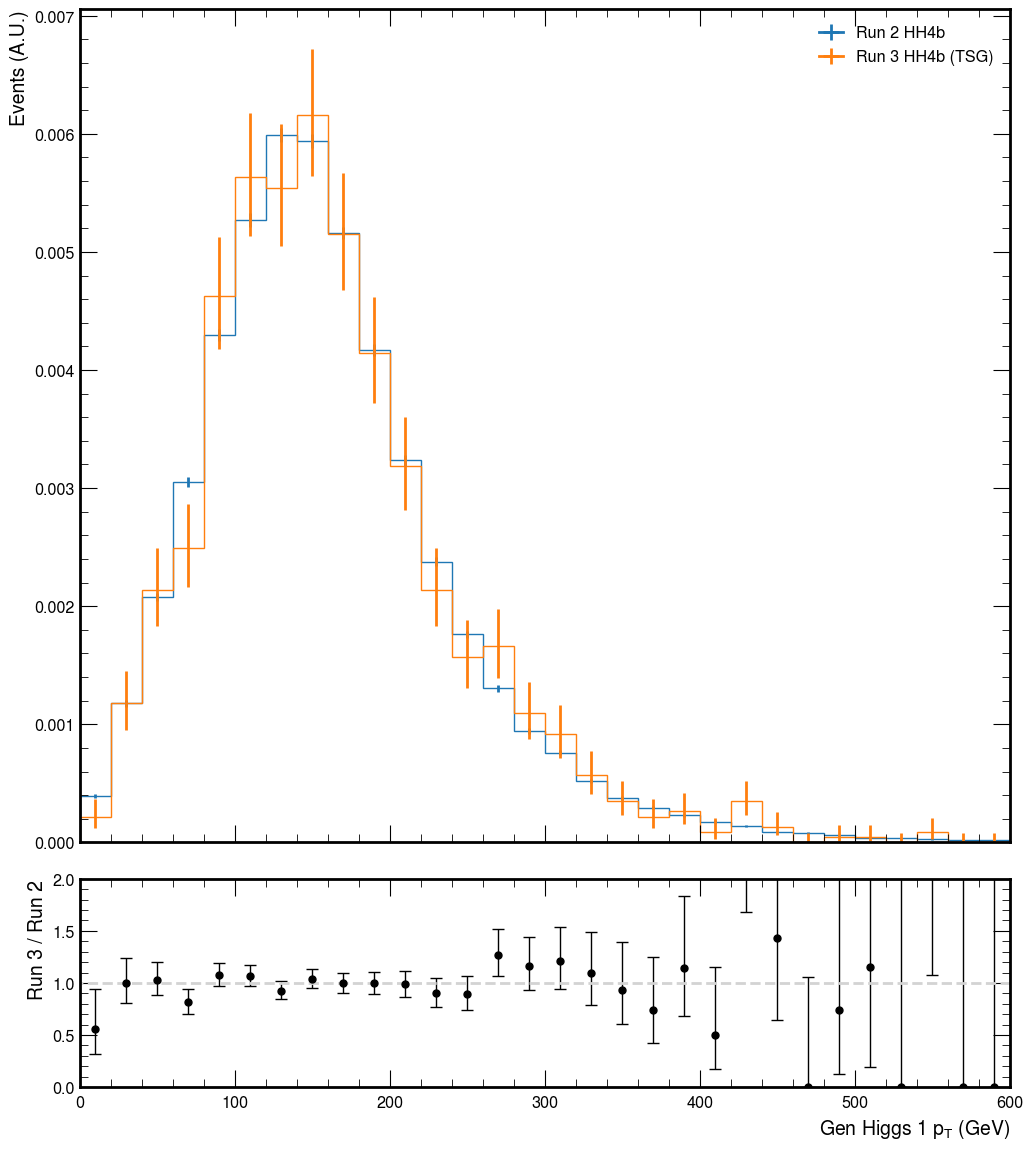

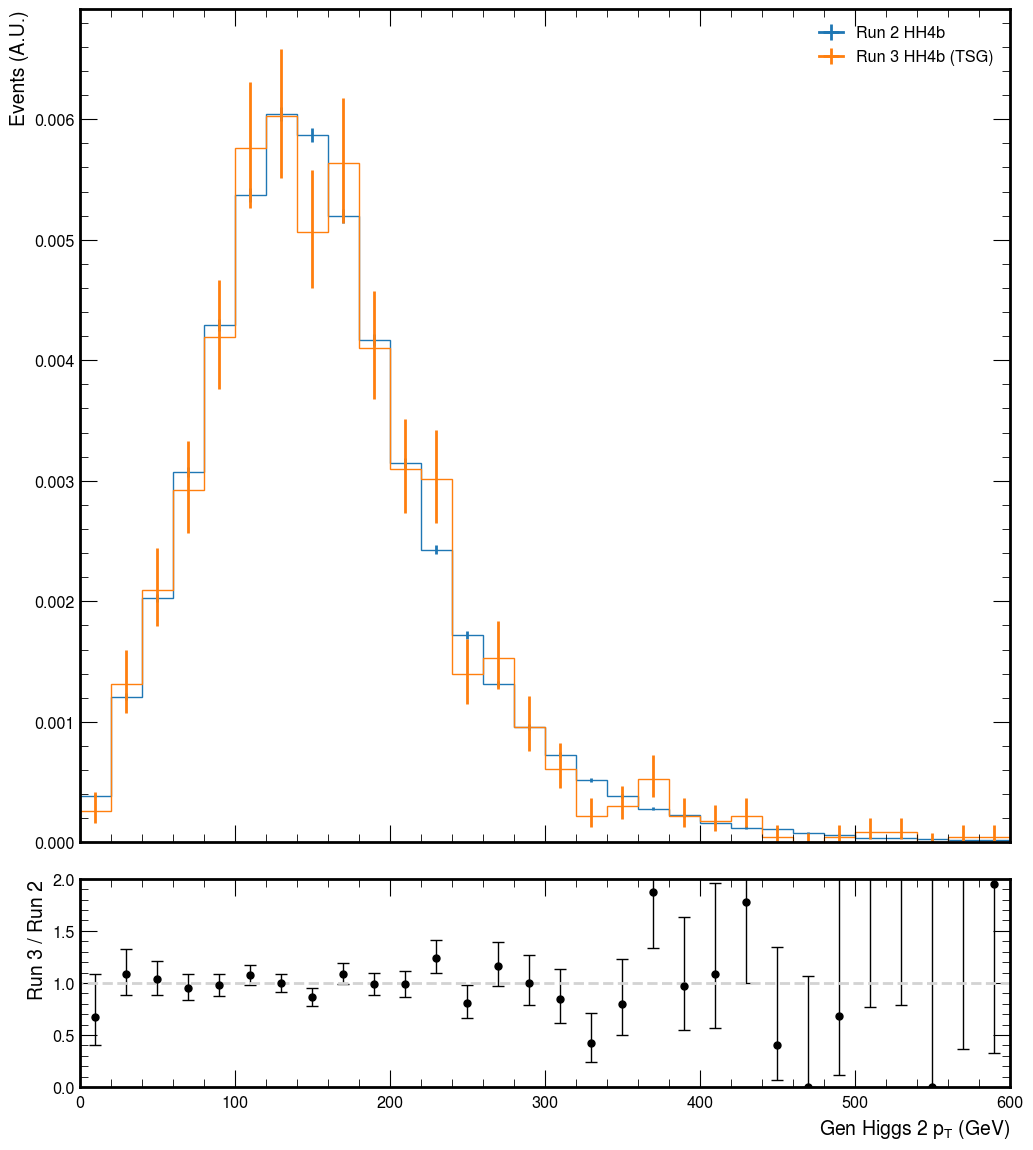

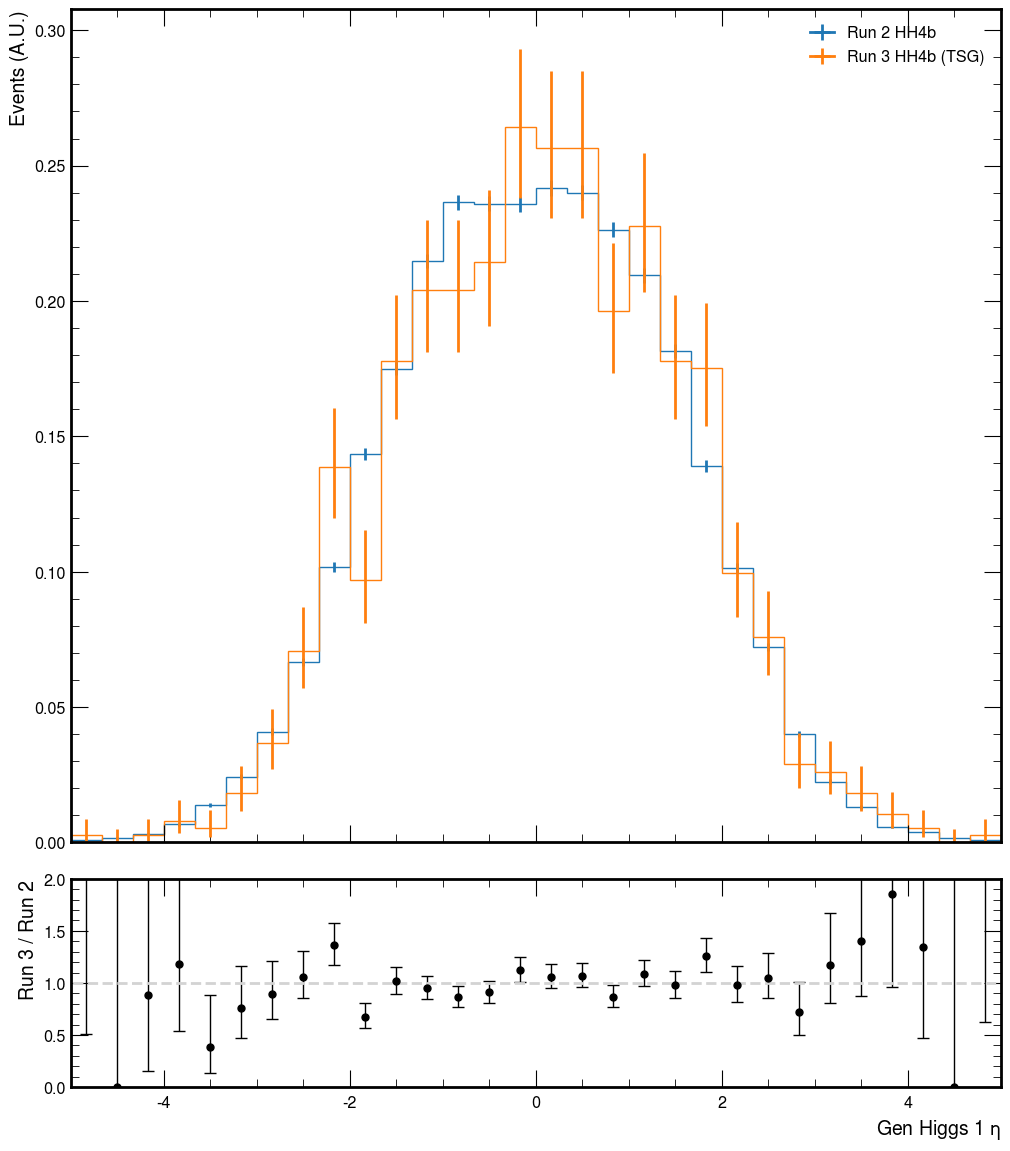

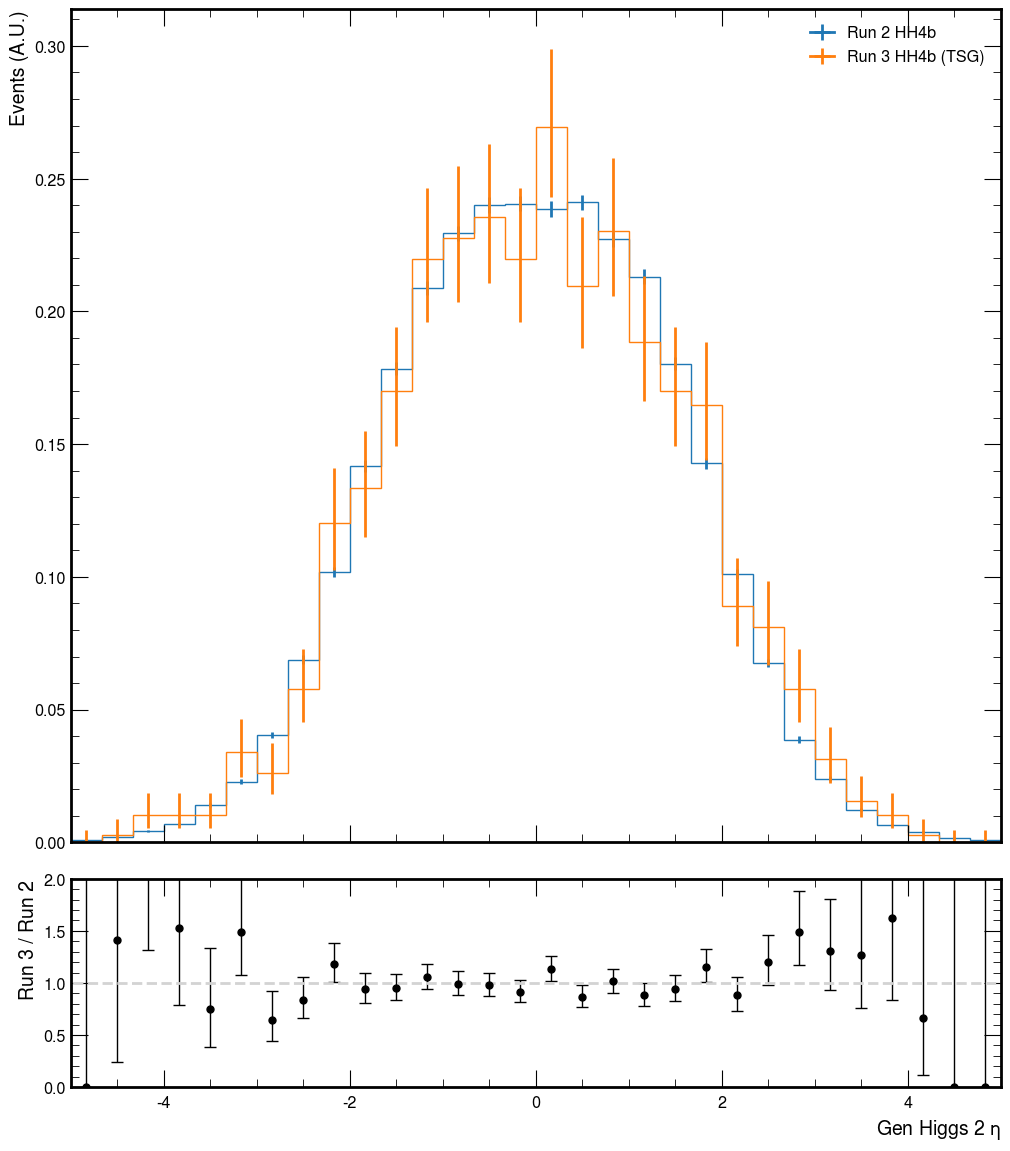

In [9]:
for var, (bins, var_label) in higgs_var_map.items():
    for i in range(2):
        fig, (ax, rax) = plt.subplots(
            2, 1, figsize=(12, 14), gridspec_kw=dict(height_ratios=[4, 1], hspace=0.07), sharex=True
        )

        hists = []

        for key, genvars in higgs_dict.items():
            h = np.histogram(genvars["higgs"][var][:, i], bins)
            hep.histplot(
                h,
                yerr=True,
                label=key_label_map[key],
                density=True,
                ax=ax,
            )

            hists.append(h[0])

        ax.set_ylabel("Events (A.U.)")
        ax.set_xlim(bins[0], bins[-1])
        ax.legend(fancybox=True)

        scale = np.sum(hists[0]) / np.sum(hists[1])
        yerr = ratio_uncertainty(hists[1], hists[0], "poisson-ratio") * scale
        hep.histplot(
            hists[1] / hists[0] * scale,
            bins,
            yerr=yerr,
            ax=rax,
            histtype="errorbar",
            color="black",
            capsize=4,
        )

        rax.hlines(1, -1000, bins[-1], color="lightgray", linestyles="--")
        rax.set_xlabel(f"Gen Higgs {i + 1} {var_label}")
        rax.set_ylabel("Run 3 / Run 2")
        rax.set_ylim([0, 2])
        # plt.legend()
        plt.savefig(f"{plot_dir}/higgs{i}_{var}.pdf", bbox_inches="tight")
        plt.show()

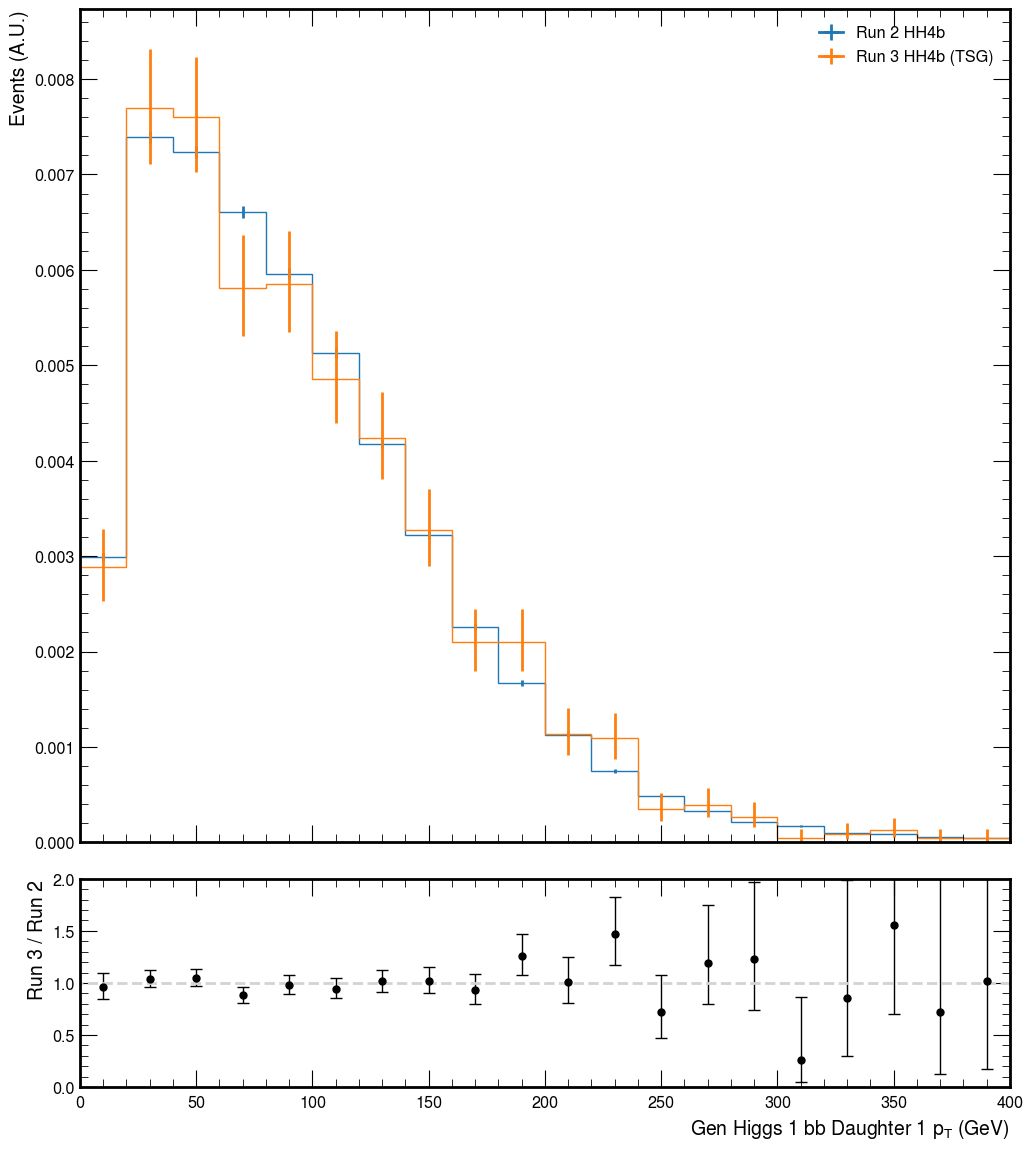

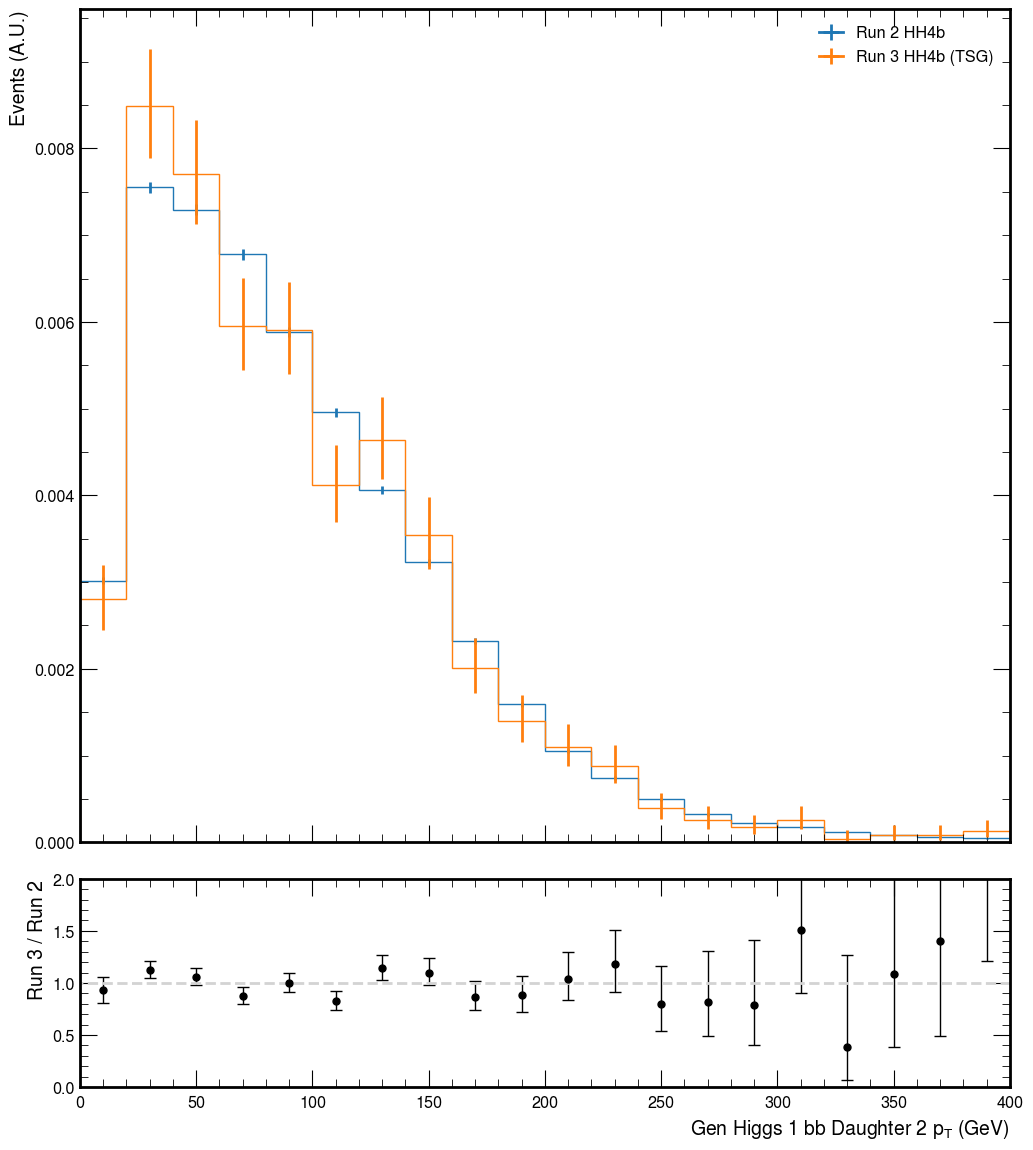

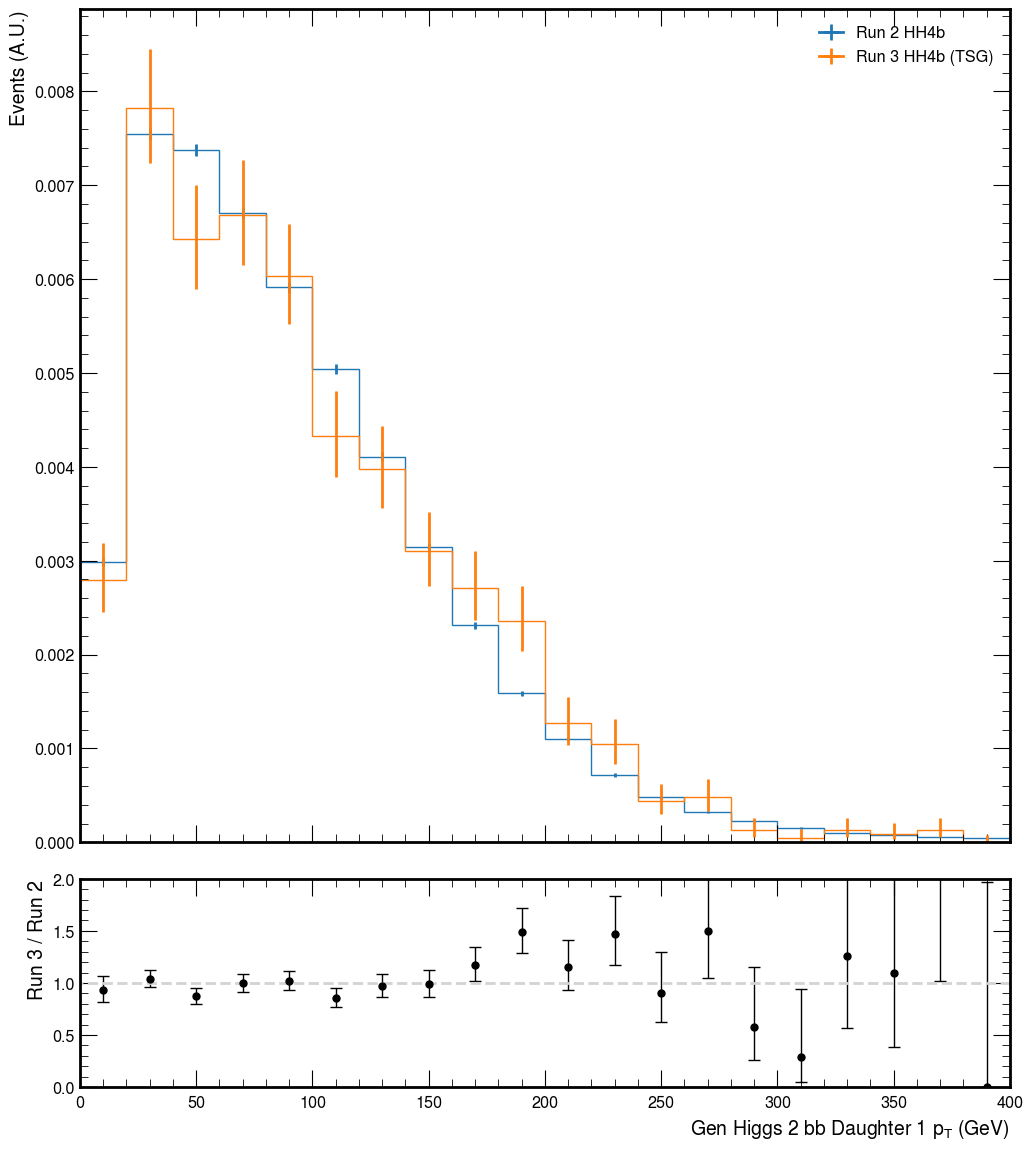

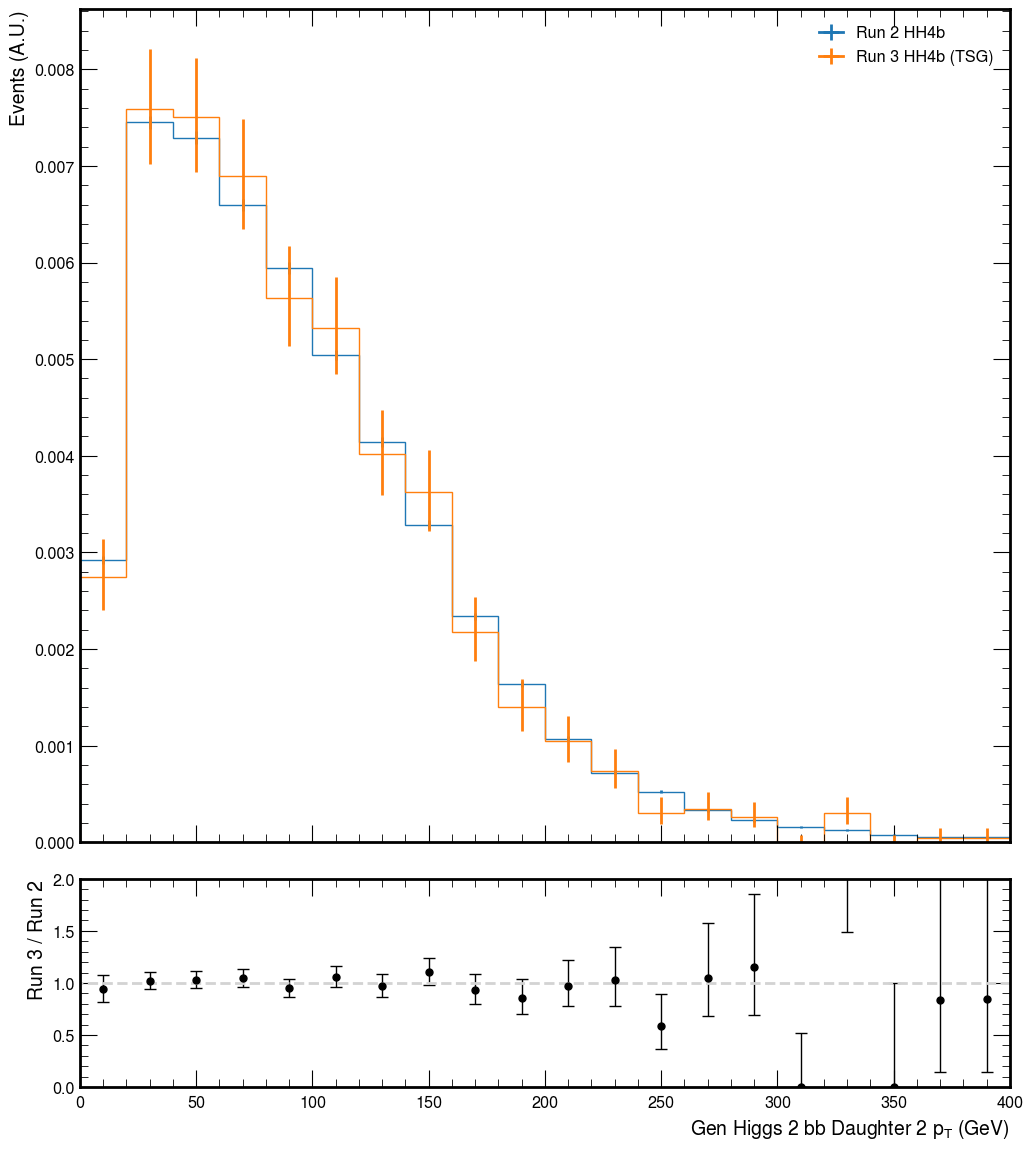

In [10]:
for var, (bins, var_label) in bb_var_map.items():
    for i in range(2):
        for j in range(2):
            fig, (ax, rax) = plt.subplots(
                2,
                1,
                figsize=(12, 14),
                gridspec_kw=dict(height_ratios=[4, 1], hspace=0.07),
                sharex=True,
            )

            hists = []

            for key, genvars in higgs_dict.items():
                h = np.histogram(genvars[f"bb{i}"][var][:, j], bins)
                hep.histplot(
                    h,
                    yerr=True,
                    label=key_label_map[key],
                    density=True,
                    ax=ax,
                )
                hists.append(h[0])

            ax.set_ylabel("Events (A.U.)")
            ax.set_xlim(bins[0], bins[-1])
            ax.legend(fancybox=True)

            scale = np.sum(hists[0]) / np.sum(hists[1])
            yerr = ratio_uncertainty(hists[1], hists[0], "poisson-ratio") * scale
            hep.histplot(
                hists[1] / hists[0] * scale,
                bins,
                yerr=yerr,
                ax=rax,
                histtype="errorbar",
                color="black",
                capsize=4,
            )

            rax.hlines(1, -1000, bins[-1], color="lightgray", linestyles="--")
            rax.set_xlabel(f"Gen Higgs {i + 1} bb Daughter {j + 1} {var_label}")
            rax.set_ylabel("Run 3 / Run 2")
            rax.set_ylim([0, 2])

            plt.savefig(f"{plot_dir}/higgs{i}_bb{j}_{var}.pdf", bbox_inches="tight")
            plt.show()

## Trigger comparison

### Signal

Run 3 Triggers

In [11]:
HLTs = ["AK8PFJet250_SoftDropMass40_PFAK8ParticleNetBB0p35", "AK8PFJet425_SoftDropMass40"]

events = events_dict["run3"]

HLT_triggered = np.any(
    np.array([events.HLT[trigger] for trigger in HLTs]),
    axis=0,
)

Run 2 Trigger Efficiencies

In [12]:
def pad_val(
    arr: ak.Array,
    target: int,
    value: float = 0,
    axis: int = 0,
    to_numpy: bool = True,
    clip: bool = True,
):
    """
    pads awkward array up to ``target`` index along axis ``axis`` with value ``value``,
    optionally converts to numpy array
    """
    ret = ak.fill_none(ak.pad_none(arr, target, axis=axis, clip=clip), value, axis=axis)
    return ret.to_numpy() if to_numpy else ret


def trig_effs(fatjets, year: str = "2018", num_jets: int = 2):
    """Add the trigger efficiencies we measured in SingleMuon data"""
    with open(f"../corrections/data/{year}_triggereff_combined.pkl", "rb") as filehandler:
        combined = pickle.load(filehandler)

    # sum over TH4q bins
    effs_txbb = combined["num"][:, sum, :, :] / combined["den"][:, sum, :, :]

    ak8TrigEffsLookup = dense_lookup(
        np.nan_to_num(effs_txbb.view(flow=False), 0), np.squeeze(effs_txbb.axes.edges)
    )

    # TODO: confirm that these should be corrected pt, msd values
    fj_trigeffs = ak8TrigEffsLookup(
        pad_val(fatjets.Txbb, num_jets, 0, axis=1),
        pad_val(fatjets.pt, num_jets, 0, axis=1),
        pad_val(fatjets.msoftdrop, num_jets, 0, axis=1),
    )

    # combined eff = 1 - (1 - fj1_eff) * (1 - fj2_eff)
    combined_trigEffs = 1 - np.prod(1 - fj_trigeffs, axis=1)
    return combined_trigEffs

In [13]:
fatjets = events_dict["run2"].FatJet
fatjets.Txbb = fatjets.particleNetMD_Xbb / (fatjets.particleNetMD_QCD + fatjets.particleNetMD_Xbb)
trigeffs = trig_effs(fatjets)

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/awkward/_connect/_numpy.py:197: RuntimeWarning: invalid value encountered in divide
  result = getattr(ufunc, method)(


Plots

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:192: RuntimeWarning: invalid value encountered in divide
  ufunc(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:198: RuntimeWarning: divide by zero encountered in divide
  ufunc(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:198: RuntimeWarning: invalid value encountered in divide
  ufunc(


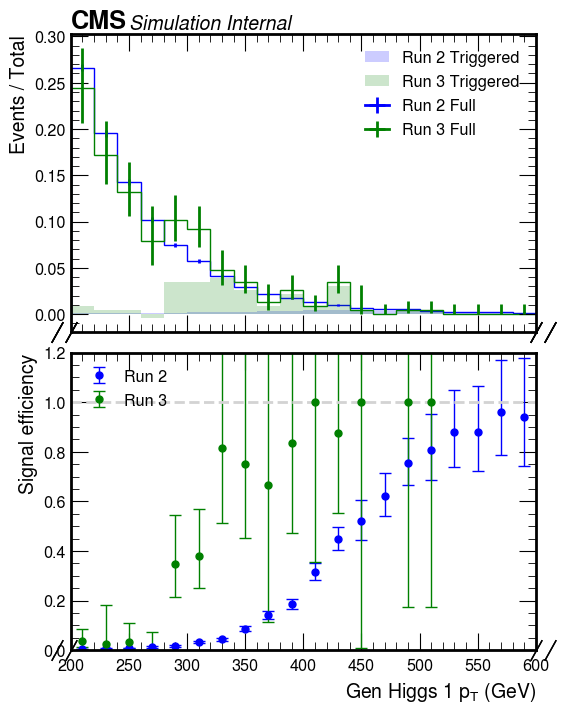

In [14]:
higgs_var_map = {
    "pt": ([20, 200, 600], r"$p_T$ (GeV)"),
}

key_label_map = {
    "run2": "Run 2",
    "run3": "Run 3",
}

hists = {}

colors = {"run2": "blue", "run3": "green"}

for var, (bins, var_label) in higgs_var_map.items():
    for i in range(1):
        fig, (ax, rax) = plt.subplots(
            2,
            1,
            figsize=(6, 8),
            gridspec_kw=dict(height_ratios=[1, 1], hspace=0.07),
            sharex=True,
        )

        for key, genvars in higgs_dict.items():
            higgs = genvars["higgs"]
            events = events_dict[key]
            run_label = key_label_map[key]

            hf = Hist.new.Reg(*bins, name=var, label=var_label).Weight()
            hf.fill(higgs[var][:, i], weight=events.genWeight)
            tot = np.sum(hf.values())

            hep.histplot(
                hf / tot,
                yerr=True,
                label=f"{run_label} Full",
                color=colors[key],
                ax=ax,
            )

            ht = Hist.new.Reg(*bins, name=var, label=var_label).Weight()
            if key == "run3":
                ht.fill(higgs[var][:, i][HLT_triggered], weight=events.genWeight[HLT_triggered])
            else:
                ht.fill(higgs[var][:, i], weight=events.genWeight * trigeffs)

            hep.histplot(
                ht / tot,
                yerr=True,
                label=f"{run_label} Triggered",
                histtype="fill",
                alpha=0.2,
                facecolor=colors[key],
                color=colors[key],
                ax=ax,
            )

            num = ht
            den = hf.values()
            num_values = ht.values()
            hep.histplot(
                num / den,
                # yerr=abs(clopper_pearson_interval(num_values, den) - num_values / den),
                yerr=True,
                ax=rax,
                histtype="errorbar",
                capsize=4,
                color=colors[key],
                label=run_label,
            )

            hists[key] = {"full": hf, "triggered": ht}

        ax.set_xlabel(None)
        ax.set_ylabel("Events / Total")
        ax.set_xlim(bins[1], bins[2])
        ax.legend(fancybox=True)

        rax.hlines(1, bins[1], bins[2], color="lightgray", linestyles="--")
        rax.set_xlabel(f"Gen Higgs {i + 1} {var_label}")
        rax.set_ylabel("Signal efficiency")
        rax.set_ylim([0, 1.2])
        rax.legend()

        hep.cms.text(
            "Simulation Internal",
            ax=ax,
        )

        plt.savefig(f"{plot_dir}/signal_trigger_effs.pdf", bbox_inches="tight")
        plt.show()

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:192: RuntimeWarning: invalid value encountered in divide
  ufunc(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:198: RuntimeWarning: invalid value encountered in divide
  ufunc(


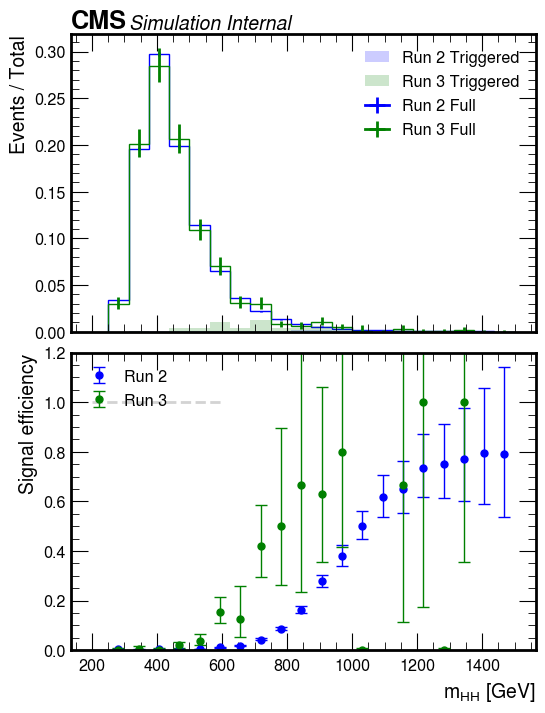

In [15]:
hists = {}

fig, (ax, rax) = plt.subplots(
    2,
    1,
    figsize=(6, 8),
    gridspec_kw=dict(height_ratios=[1, 1], hspace=0.07),
    sharex=True,
)

for key, genvars in higgs_dict.items():
    events = events_dict[key]
    run_label = key_label_map[key]
    mhh = genvars["hh"].mass

    hf = Hist.new.Reg(20, 250, 1500, name="mhh", label=r"m$_{HH}$ [GeV]").Weight()
    hf.fill(mhh, weight=events.genWeight)
    tot = np.sum(hf.values())

    hep.histplot(
        hf / tot,
        yerr=True,
        label=f"{run_label} Full",
        color=colors[key],
        ax=ax,
        flow="none",
    )

    ht = Hist.new.Reg(20, 250, 1500, name="mhh", label=r"m$_{HH}$ [GeV]").Weight()
    if key == "run3":
        ht.fill(mhh[HLT_triggered], weight=events.genWeight[HLT_triggered])
    else:
        ht.fill(mhh, weight=events.genWeight * trigeffs)

    hep.histplot(
        ht / tot,
        yerr=True,
        label=f"{run_label} Triggered",
        histtype="fill",
        alpha=0.2,
        facecolor=colors[key],
        color=colors[key],
        ax=ax,
        flow="none",
    )

    num = ht
    den = hf.values()
    num_values = ht.values()
    hep.histplot(
        num / den,
        # yerr=abs(clopper_pearson_interval(num_values, den) - num_values / den),
        yerr=True,
        ax=rax,
        histtype="errorbar",
        capsize=4,
        color=colors[key],
        label=run_label,
        flow="none",
    )

    hists[key] = {"full": hf, "triggered": ht}

ax.set_xlabel(None)
ax.set_ylabel("Events / Total")
ax.legend(fancybox=True)

rax.hlines(1, bins[1], bins[2], color="lightgray", linestyles="--")
rax.set_ylabel("Signal efficiency")
rax.set_ylim([0, 1.2])
rax.legend()

hep.cms.text(
    "Simulation Internal",
    ax=ax,
)

plt.savefig(f"{plot_dir}/signal_trigger_eff_mhh.pdf", bbox_inches="tight")
plt.show()

In [16]:
events_dict["run2"].FatJet[:, 0:1].pt

<Array [[236], [312], ... 222], [], [262]] type='87400 * var * float32[parameter...'>

/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:192: RuntimeWarning: invalid value encountered in divide
  ufunc(
/uscms/home/cmantill/nobackup/miniconda3/envs/coffea-env/lib/python3.8/site-packages/boost_histogram/_internal/view.py:198: RuntimeWarning: invalid value encountered in divide
  ufunc(


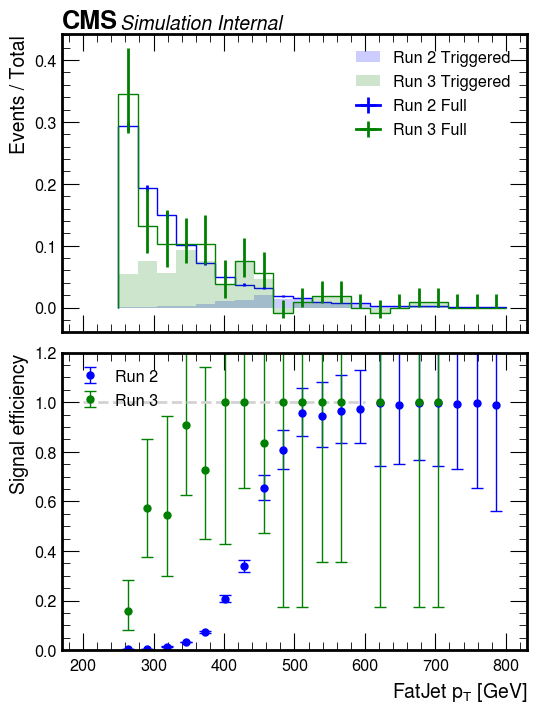

In [17]:
hists = {}

fig, (ax, rax) = plt.subplots(
    2,
    1,
    figsize=(6, 8),
    gridspec_kw=dict(height_ratios=[1, 1], hspace=0.07),
    sharex=True,
)

for key, genvars in higgs_dict.items():
    events = events_dict[key]
    run_label = key_label_map[key]
    pt = pad_val(ak.firsts(events.FatJet[:, 0:1].pt), len(events.genWeight))

    hf = Hist.new.Reg(20, 250, 800, name="pt", label=r"FatJet p$_T$ [GeV]").Weight()
    hf.fill(pt, weight=events.genWeight)
    tot = np.sum(hf.values())

    hep.histplot(
        hf / tot,
        yerr=True,
        label=f"{run_label} Full",
        color=colors[key],
        ax=ax,
        flow="none",
    )

    ht = Hist.new.Reg(20, 250, 800, name="pt", label=r"FatJet p$_T$ [GeV]").Weight()
    if key == "run3":
        ht.fill(pt[HLT_triggered], weight=events.genWeight[HLT_triggered])
    else:
        ht.fill(pt, weight=events.genWeight * trigeffs)

    hep.histplot(
        ht / tot,
        yerr=True,
        label=f"{run_label} Triggered",
        histtype="fill",
        alpha=0.2,
        facecolor=colors[key],
        color=colors[key],
        ax=ax,
        flow="none",
    )

    num = ht
    den = hf.values()
    num_values = ht.values()
    hep.histplot(
        num / den,
        # yerr=abs(clopper_pearson_interval(num_values, den) - num_values / den),
        yerr=True,
        ax=rax,
        histtype="errorbar",
        capsize=4,
        color=colors[key],
        label=run_label,
        flow="none",
    )

    hists[key] = {"full": hf, "triggered": ht}

ax.set_xlabel(None)
ax.set_ylabel("Events / Total")
ax.legend(fancybox=True)

rax.hlines(1, bins[1], bins[2], color="lightgray", linestyles="--")
rax.set_ylabel("Signal efficiency")
rax.set_ylim([0, 1.2])
rax.legend()

hep.cms.text(
    "Simulation Internal",
    ax=ax,
)

plt.savefig(f"{plot_dir}/signal_trigger_effs_pt.pdf", bbox_inches="tight")
plt.show()

In [18]:
for key in hists:
    print(key)
    print("Total efficiency H1 > 200")
    print(np.sum(hists[key]["triggered"].values()) / np.sum(hists[key]["full"].values()))
    print("Total efficiency H1 > 300")
    print(np.sum(hists[key]["triggered"].values()[5:]) / np.sum(hists[key]["full"].values()[5:]))

run2
Total efficiency H1 > 200
0.12313539423097132
Total efficiency H1 > 300
0.5776819614438262
run3
Total efficiency H1 > 200
0.5599993542090855
Total efficiency H1 > 300
0.9565217391304348
